In [109]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [110]:
import numpy as np
import pandas as pd

In [111]:
import datetime as dt
import seaborn as sns

# Reflect Tables into SQLAlchemy ORM

In [112]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [113]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [114]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [115]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [116]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [117]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [118]:
#query the database for a years worth of precipitation data. Focus on most recent.
analysis = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()

In [119]:
analysis_df = pd.DataFrame(analysis)
analysis_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [120]:
#convert date from  string to date
analysis_df['date'] = pd.to_datetime(analysis_df['date'])
analysis_df = analysis_df.set_index('date')
analysis_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


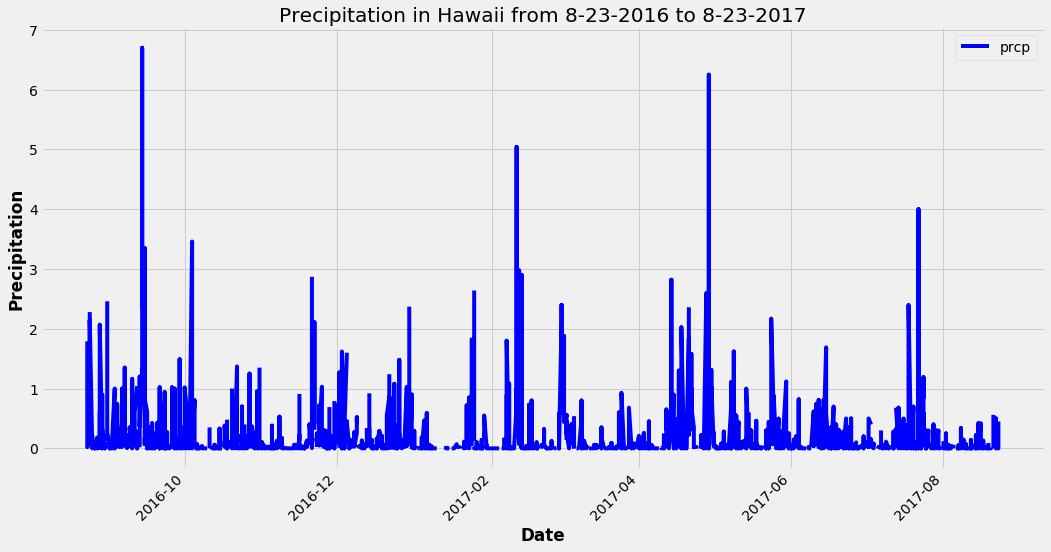

In [121]:
#plot the data
analysis_plot = analysis_df.plot(figsize = (16, 9), sort_columns=True, rot=45, use_index=True, legend=True, grid=True, color='b')
plt.ylabel('Precipitation', weight='bold')
plt.xlabel('Date', weight='bold')
plt.title("Precipitation in Hawaii from 8-23-2016 to 8-23-2017")
sns.despine()
plt.show()

In [122]:
#Statistical Analysis

analysis_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [123]:
# Design a query to show how many stations are available in this dataset?
station_num = session.query(Station.id).count()
station_num


9

In [124]:
# Query to find observation counts by station
obs_counts = session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc())

# Printing observations
for station in obs_counts:
    print(station)
    
# Storing station name
top_station = obs_counts[0][0]

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [125]:
top_station

'USC00519281'

In [126]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temp_data = []
max_temp = session.query(Measurement.tobs, func.max(Measurement.tobs)).filter(Measurement.station == top_station)
for row in max_temp:
    temp_data.append(row[0])
    
min_temp = session.query(Measurement.tobs, func.min(Measurement.tobs)).filter(Measurement.station == top_station)
for row in min_temp:
    temp_data.append(row[0])

avg_temp = session.query(Measurement.tobs, func.avg(Measurement.tobs)).filter(Measurement.station == top_station)
for row in avg_temp:
    temp_data.append(row[0])

temp_data

[85.0, 54.0, 79.0]

In [127]:
temp = session.query(Measurement.tobs).filter(Measurement.date >= "2016-08-23").filter(Measurement.date <= "2017-08-23").filter(Measurement.station == top_station)

tobs_data = []
for row in temp:
    tobs_data.append(row[0])
    


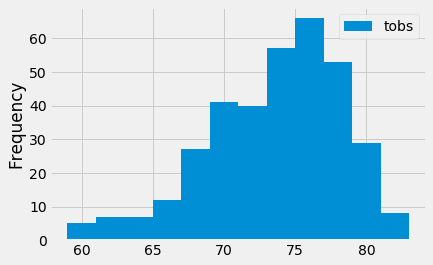

In [128]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


plt.hist(tobs_data, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend()
plt.savefig("Images/station_analysis.png")
plt.show()

In [129]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [130]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temp_data = calc_temps('2012-02-28', '2012-03-05')

list(temp_data)


[(62.0, 69.57142857142857, 74.0)]

In [131]:

# Calling function
temp_analysis = list(calc_temps('2015-08-28', '2015-09-07')[0])

# Creating variables
tavg = temp_analysis[0]
tmin = temp_analysis[1]
tmax = temp_analysis[2]

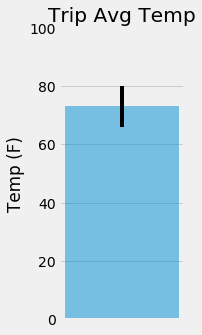

In [132]:
plt.figure(figsize=(2,5))
plt.bar(1,height=tavg, yerr=(tmax-tmin), width=0.0001, alpha=0.5)
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.savefig("Images/temperature_analysis.png")
plt.show()

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
